# SNS Take Home Assessment

### Libraries

In [14]:
import numpy as np
import pandas as pd
import torch
import nltk
import os
import time
import shutil
from matplotlib import pyplot as plt
from torchvision import datasets, transforms, models
import torch.nn as nn
from torch.utils.data import DataLoader
import argparse
import torch.optim as optim
from torchvision.datasets import ImageFolder
import seaborn as sns
from sklearn.metrics import confusion_matrix
from fastai import *
from fastai.vision import *
import csv
from scipy.io import loadmat

### Importing dataset

In [15]:
class_names = pd.read_csv("./Stanford Cars Dataset/annotations/class_names.csv", header = None, names = ['Models'])
car_annot = pd.read_csv("./Stanford Cars Dataset/annotations/cars_annos.csv", header = None, names = ['Raw'])

In [16]:
class_names.head()

,Models
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012


In [17]:
car_annot.head()

,Raw
0,Image;x1;y1;x2;y2;class;test
1,000001.jpg;112;7;853;717;1;0
2,000002.jpg;48;24;441;202;1;0
3,000003.jpg;7;4;277;180;1;0
4,000004.jpg;33;50;197;150;1;0


### Pre-Processing

In [18]:
car_annot2 = car_annot.copy()

In [19]:
def split_text(text):
    split = text.split(";")
    return split

In [20]:
car_annot2[["Image","x1", "y1","x2","y2","Class","Test"]] = car_annot2['Raw'].str.split(";", expand = True)

In [21]:
car_annot2 = car_annot2.iloc[1: ,1:]

In [22]:
car_annot2

,Image,x1,y1,x2,y2,Class,Test
1,000001.jpg,112,7,853,717,1,0
2,000002.jpg,48,24,441,202,1,0
3,000003.jpg,7,4,277,180,1,0
4,000004.jpg,33,50,197,150,1,0
5,000005.jpg,5,8,83,58,1,0
...,...,...,...,...,...,...,...
16181,016181.jpg,38,36,375,234,196,1
16182,016182.jpg,29,34,235,164,196,1
16183,016183.jpg,25,32,587,359,196,1
16184,016184.jpg,56,60,208,186,196,1


In [23]:
car_annot2["Class"] = pd.to_numeric(car_annot2.Class)

In [24]:
class_names

,Models
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
...,...
191,Volkswagen Beetle Hatchback 2012
192,Volvo C30 Hatchback 2012
193,Volvo 240 Sedan 1993
194,Volvo XC90 SUV 2007


In [25]:
models_dict = class_names.to_dict("dict")

In [26]:
models_dict

{'Models': {0: 'AM General Hummer SUV 2000',
  1: 'Acura RL Sedan 2012',
  2: 'Acura TL Sedan 2012',
  3: 'Acura TL Type-S 2008',
  4: 'Acura TSX Sedan 2012',
  5: 'Acura Integra Type R 2001',
  6: 'Acura ZDX Hatchback 2012',
  7: 'Aston Martin V8 Vantage Convertible 2012',
  8: 'Aston Martin V8 Vantage Coupe 2012',
  9: 'Aston Martin Virage Convertible 2012',
  10: 'Aston Martin Virage Coupe 2012',
  11: 'Audi RS 4 Convertible 2008',
  12: 'Audi A5 Coupe 2012',
  13: 'Audi TTS Coupe 2012',
  14: 'Audi R8 Coupe 2012',
  15: 'Audi V8 Sedan 1994',
  16: 'Audi 100 Sedan 1994',
  17: 'Audi 100 Wagon 1994',
  18: 'Audi TT Hatchback 2011',
  19: 'Audi S6 Sedan 2011',
  20: 'Audi S5 Convertible 2012',
  21: 'Audi S5 Coupe 2012',
  22: 'Audi S4 Sedan 2012',
  23: 'Audi S4 Sedan 2007',
  24: 'Audi TT RS Coupe 2012',
  25: 'BMW ActiveHybrid 5 Sedan 2012',
  26: 'BMW 1 Series Convertible 2012',
  27: 'BMW 1 Series Coupe 2012',
  28: 'BMW 3 Series Sedan 2012',
  29: 'BMW 3 Series Wagon 2012',
  30

In [27]:
car_annot2["Class"] = car_annot2["Class"]-1

In [28]:
car_annot2

,Image,x1,y1,x2,y2,Class,Test
1,000001.jpg,112,7,853,717,0,0
2,000002.jpg,48,24,441,202,0,0
3,000003.jpg,7,4,277,180,0,0
4,000004.jpg,33,50,197,150,0,0
5,000005.jpg,5,8,83,58,0,0
...,...,...,...,...,...,...,...
16181,016181.jpg,38,36,375,234,195,1
16182,016182.jpg,29,34,235,164,195,1
16183,016183.jpg,25,32,587,359,195,1
16184,016184.jpg,56,60,208,186,195,1


In [29]:
car_annot3 = car_annot2.copy()

In [30]:
# Mapping Class number to Model
car_annot3["Models"] = car_annot3["Class"].map(models_dict['Models'])

In [31]:
car_annot3

,Image,x1,y1,x2,y2,Class,Test,Models
1,000001.jpg,112,7,853,717,0,0,AM General Hummer SUV 2000
2,000002.jpg,48,24,441,202,0,0,AM General Hummer SUV 2000
3,000003.jpg,7,4,277,180,0,0,AM General Hummer SUV 2000
4,000004.jpg,33,50,197,150,0,0,AM General Hummer SUV 2000
5,000005.jpg,5,8,83,58,0,0,AM General Hummer SUV 2000
...,...,...,...,...,...,...,...,...
16181,016181.jpg,38,36,375,234,195,1,smart fortwo Convertible 2012
16182,016182.jpg,29,34,235,164,195,1,smart fortwo Convertible 2012
16183,016183.jpg,25,32,587,359,195,1,smart fortwo Convertible 2012
16184,016184.jpg,56,60,208,186,195,1,smart fortwo Convertible 2012


### Split into 2 dataframes - Train and Test

In [32]:
pd.options.mode.chained_assignment = None       # Removes warning message

In [33]:
train_annot = car_annot3.loc[(car_annot3["Test"] == "0")]
test_annot = car_annot3.loc[(car_annot3["Test"] == "1")]

### Make bounding boxes

In [34]:
train_annot['y2'] = train_annot['y2'].astype(int)
train_annot['y1'] = train_annot['y1'].astype(int)
train_annot['x2'] = train_annot['x2'].astype(int)
train_annot['x1'] = train_annot['x1'].astype(int)

In [35]:
train_annot['bbox_h'] = ((train_annot['y2'] - train_annot['y1']) + 1)
train_annot['bbox_w'] = ((train_annot['x2'] - train_annot['x1']) + 1)

In [36]:
train_annot

,Image,x1,y1,x2,y2,Class,Test,Models,bbox_h,bbox_w
1,000001.jpg,112,7,853,717,0,0,AM General Hummer SUV 2000,711,742
2,000002.jpg,48,24,441,202,0,0,AM General Hummer SUV 2000,179,394
3,000003.jpg,7,4,277,180,0,0,AM General Hummer SUV 2000,177,271
4,000004.jpg,33,50,197,150,0,0,AM General Hummer SUV 2000,101,165
5,000005.jpg,5,8,83,58,0,0,AM General Hummer SUV 2000,51,79
...,...,...,...,...,...,...,...,...,...,...
16141,016141.jpg,42,9,573,366,195,0,smart fortwo Convertible 2012,358,532
16142,016142.jpg,183,4,1186,780,195,0,smart fortwo Convertible 2012,777,1004
16143,016143.jpg,121,87,465,278,195,0,smart fortwo Convertible 2012,192,345
16144,016144.jpg,21,30,468,320,195,0,smart fortwo Convertible 2012,291,448


In [37]:
train_annot.to_csv("./Stanford Cars Dataset/annotations/train_annots.csv")

In [38]:
test_annot

,Image,x1,y1,x2,y2,Class,Test,Models
46,000046.jpg,14,16,268,169,0,1,AM General Hummer SUV 2000
47,000047.jpg,10,18,89,61,0,1,AM General Hummer SUV 2000
48,000048.jpg,111,54,365,190,0,1,AM General Hummer SUV 2000
49,000049.jpg,9,33,479,276,0,1,AM General Hummer SUV 2000
50,000050.jpg,9,3,93,41,0,1,AM General Hummer SUV 2000
...,...,...,...,...,...,...,...,...
16181,016181.jpg,38,36,375,234,195,1,smart fortwo Convertible 2012
16182,016182.jpg,29,34,235,164,195,1,smart fortwo Convertible 2012
16183,016183.jpg,25,32,587,359,195,1,smart fortwo Convertible 2012
16184,016184.jpg,56,60,208,186,195,1,smart fortwo Convertible 2012


In [39]:
test_annot['y2'] = test_annot['y2'].astype(int)
test_annot['y1'] = test_annot['y1'].astype(int)
test_annot['x2'] = test_annot['x2'].astype(int)
test_annot['x1'] = test_annot['x1'].astype(int)

In [40]:
test_annot['bbox_h'] = ((test_annot['y2'] - test_annot['y1']) + 1)
test_annot['bbox_w'] = ((test_annot['x2'] - test_annot['x1']) + 1)

In [41]:
test_annot

,Image,x1,y1,x2,y2,Class,Test,Models,bbox_h,bbox_w
46,000046.jpg,14,16,268,169,0,1,AM General Hummer SUV 2000,154,255
47,000047.jpg,10,18,89,61,0,1,AM General Hummer SUV 2000,44,80
48,000048.jpg,111,54,365,190,0,1,AM General Hummer SUV 2000,137,255
49,000049.jpg,9,33,479,276,0,1,AM General Hummer SUV 2000,244,471
50,000050.jpg,9,3,93,41,0,1,AM General Hummer SUV 2000,39,85
...,...,...,...,...,...,...,...,...,...,...
16181,016181.jpg,38,36,375,234,195,1,smart fortwo Convertible 2012,199,338
16182,016182.jpg,29,34,235,164,195,1,smart fortwo Convertible 2012,131,207
16183,016183.jpg,25,32,587,359,195,1,smart fortwo Convertible 2012,328,563
16184,016184.jpg,56,60,208,186,195,1,smart fortwo Convertible 2012,127,153


In [42]:
test_annot.to_csv("./Stanford Cars Dataset/annotations/test_annots.csv")

### Move images into train and test folders respectively

In [43]:
movdir = "./Stanford Cars Dataset/car_im_train/"
basedir = "./Stanford Cars Dataset/car_ims/"


count = 0
for i in train_annot["Image"]:
    shutil.copy(basedir+i, movdir+i)
    count += 1
    print("Copied:", count)

Copied: 1
Copied: 2
Copied: 3
Copied: 4
Copied: 5
Copied: 6
Copied: 7
Copied: 8
Copied: 9
Copied: 10
Copied: 11
Copied: 12
Copied: 13
Copied: 14
Copied: 15
Copied: 16
Copied: 17
Copied: 18
Copied: 19
Copied: 20
Copied: 21
Copied: 22
Copied: 23
Copied: 24
Copied: 25
Copied: 26
Copied: 27
Copied: 28
Copied: 29
Copied: 30
Copied: 31
Copied: 32
Copied: 33
Copied: 34
Copied: 35
Copied: 36
Copied: 37
Copied: 38
Copied: 39
Copied: 40
Copied: 41
Copied: 42
Copied: 43
Copied: 44
Copied: 45
Copied: 46
Copied: 47
Copied: 48
Copied: 49
Copied: 50
Copied: 51
Copied: 52
Copied: 53
Copied: 54
Copied: 55
Copied: 56
Copied: 57
Copied: 58
Copied: 59
Copied: 60
Copied: 61
Copied: 62
Copied: 63
Copied: 64
Copied: 65
Copied: 66
Copied: 67
Copied: 68
Copied: 69
Copied: 70
Copied: 71
Copied: 72
Copied: 73
Copied: 74
Copied: 75
Copied: 76
Copied: 77
Copied: 78
Copied: 79
Copied: 80
Copied: 81
Copied: 82
Copied: 83
Copied: 84
Copied: 85
Copied: 86
Copied: 87
Copied: 88
Copied: 89
Copied: 90
Copied: 91
Copied: 

In [44]:
movdir = "./Stanford Cars Dataset/car_im_test/"
basedir = "./Stanford Cars Dataset/car_ims/"

count = 0
for i in test_annot["Image"]:
    shutil.copy(basedir+i, movdir+i)
    count += 1
    print("Copied:", count)

Copied: 1
Copied: 2
Copied: 3
Copied: 4
Copied: 5
Copied: 6
Copied: 7
Copied: 8
Copied: 9
Copied: 10
Copied: 11
Copied: 12
Copied: 13
Copied: 14
Copied: 15
Copied: 16
Copied: 17
Copied: 18
Copied: 19
Copied: 20
Copied: 21
Copied: 22
Copied: 23
Copied: 24
Copied: 25
Copied: 26
Copied: 27
Copied: 28
Copied: 29
Copied: 30
Copied: 31
Copied: 32
Copied: 33
Copied: 34
Copied: 35
Copied: 36
Copied: 37
Copied: 38
Copied: 39
Copied: 40
Copied: 41
Copied: 42
Copied: 43
Copied: 44
Copied: 45
Copied: 46
Copied: 47
Copied: 48
Copied: 49
Copied: 50
Copied: 51
Copied: 52
Copied: 53
Copied: 54
Copied: 55
Copied: 56
Copied: 57
Copied: 58
Copied: 59
Copied: 60
Copied: 61
Copied: 62
Copied: 63
Copied: 64
Copied: 65
Copied: 66
Copied: 67
Copied: 68
Copied: 69
Copied: 70
Copied: 71
Copied: 72
Copied: 73
Copied: 74
Copied: 75
Copied: 76
Copied: 77
Copied: 78
Copied: 79
Copied: 80
Copied: 81
Copied: 82
Copied: 83
Copied: 84
Copied: 85
Copied: 86
Copied: 87
Copied: 88
Copied: 89
Copied: 90
Copied: 91
Copied: 

### Create subfolders for each car model

In [50]:
newpath_train = "./Stanford Cars Dataset/cars_train_classes/"

for i in pd.unique(train_annot["Models"]):
    newpath_train2 = newpath_train + i
    if not os.path.exists(newpath_train2):
        os.makedirs(newpath_train2)
        print("Created folder:", newpath_train2)
    else:
        print("Folder exists")

Created folder: ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000
Created folder: ./Stanford Cars Dataset/cars_train_classes/Acura RL Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_train_classes/Acura TL Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_train_classes/Acura TL Type-S 2008
Created folder: ./Stanford Cars Dataset/cars_train_classes/Acura TSX Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_train_classes/Acura Integra Type R 2001
Created folder: ./Stanford Cars Dataset/cars_train_classes/Acura ZDX Hatchback 2012
Created folder: ./Stanford Cars Dataset/cars_train_classes/Aston Martin V8 Vantage Convertible 2012
Created folder: ./Stanford Cars Dataset/cars_train_classes/Aston Martin V8 Vantage Coupe 2012
Created folder: ./Stanford Cars Dataset/cars_train_classes/Aston Martin Virage Convertible 2012
Created folder: ./Stanford Cars Dataset/cars_train_classes/Aston Martin Virage Coupe 2012
Created folder: ./Stanford Cars Dataset/cars_tr

In [49]:
newpath_val = "./Stanford Cars Dataset/cars_val_classes/"

for i in pd.unique(train_annot["Models"]):
    newpath_val2 = newpath_val + i
    if not os.path.exists(newpath_val2):
        os.makedirs(newpath_val2)
        print("Created folder:", newpath_val2)
    else:
        print("Folder exists")

Created folder: ./Stanford Cars Dataset/cars_val_classes/AM General Hummer SUV 2000
Created folder: ./Stanford Cars Dataset/cars_val_classes/Acura RL Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Acura TL Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Acura TL Type-S 2008
Created folder: ./Stanford Cars Dataset/cars_val_classes/Acura TSX Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Acura Integra Type R 2001
Created folder: ./Stanford Cars Dataset/cars_val_classes/Acura ZDX Hatchback 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Aston Martin V8 Vantage Convertible 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Aston Martin V8 Vantage Coupe 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Aston Martin Virage Convertible 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Aston Martin Virage Coupe 2012
Created folder: ./Stanford Cars Dataset/cars_val_classes/Audi RS 4 Co

In [46]:
newpath_test = "./Stanford Cars Dataset/cars_test_classes/"

for i in pd.unique(train_annot["Models"]):
    newpath_test2 = newpath_test + i
    if not os.path.exists(newpath_test2):
        os.makedirs(newpath_test2)
        print("Created folder:", newpath_test2)
    else:
        print("Folder exists")

Created folder: ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000
Created folder: ./Stanford Cars Dataset/cars_test_classes/Acura RL Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/Acura TL Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/Acura TL Type-S 2008
Created folder: ./Stanford Cars Dataset/cars_test_classes/Acura TSX Sedan 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/Acura Integra Type R 2001
Created folder: ./Stanford Cars Dataset/cars_test_classes/Acura ZDX Hatchback 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/Aston Martin V8 Vantage Convertible 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/Aston Martin V8 Vantage Coupe 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/Aston Martin Virage Convertible 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/Aston Martin Virage Coupe 2012
Created folder: ./Stanford Cars Dataset/cars_test_classes/

### Moving images to their specific model folders

In [51]:
movdir = "./Stanford Cars Dataset/cars_train_classes/"
valdir = "./Stanford Cars Dataset/cars_val_classes/"
basedir = "./Stanford Cars Dataset/car_im_train/"

unique_models = train_annot["Models"].unique()

# Iterate over each row in the dataframe
count = 0
for index, row in train_annot.iterrows():
    
    file_name = row["Image"]
    model = row["Models"]
    # print(file_name, model)

    if count < 7000:
        # Move the file to the respective subfolder
        src_file_path = os.path.join(basedir, file_name)
        dest_file_path = os.path.join(movdir + model + "/" + file_name)

        shutil.copy(src_file_path, dest_file_path)
        print("Copying file to ", dest_file_path, " Count =", count)
        count += 1
    else:
        src_file_path = os.path.join(basedir, file_name)
        dest_file_path = os.path.join(valdir + model + "/" + file_name)

        shutil.copy(src_file_path, dest_file_path)
        print("Copying file to ", dest_file_path, " Count =", count)
        count += 1

Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000001.jpg  Count = 0
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000002.jpg  Count = 1
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000003.jpg  Count = 2
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000004.jpg  Count = 3
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000005.jpg  Count = 4
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000006.jpg  Count = 5
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000007.jpg  Count = 6
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000008.jpg  Count = 7
Copying file to  ./Stanford Cars Dataset/cars_train_classes/AM General Hummer SUV 2000/000009.jpg  Count = 8
Copying file to  ./

In [52]:
movdir = "./Stanford Cars Dataset/cars_test_classes/"
basedir = "./Stanford Cars Dataset/car_im_test/"

unique_models = test_annot["Models"].unique()

# Iterate over each row in the dataframe
count = 0
for index, row in test_annot.iterrows():
    
    file_name = row["Image"]
    model = row["Models"]
    # print(file_name, model)

    # Move the file to the respective subfolder
    src_file_path = os.path.join(basedir, file_name)
    dest_file_path = os.path.join(movdir + model + "/" + file_name)

    shutil.copy(src_file_path, dest_file_path)
    print("Copying file to ", dest_file_path, " Count =", count)
    count += 1

Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000046.jpg  Count = 0
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000047.jpg  Count = 1
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000048.jpg  Count = 2
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000049.jpg  Count = 3
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000050.jpg  Count = 4
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000051.jpg  Count = 5
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000052.jpg  Count = 6
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000053.jpg  Count = 7
Copying file to  ./Stanford Cars Dataset/cars_test_classes/AM General Hummer SUV 2000/000054.jpg  Count = 8
Copying file to  ./Stanford 

## Training model

### Hyperparameters

In [ ]:
num_epochs = 10
batch_size = 4
learning_rate = 0.01

### Prepare dataset

In [ ]:
# Set the path to your dataset
train_path = './Stanford Cars Dataset/cars_train_classes'
test_path = './Stanford Cars Dataset/cars_test_classes'

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create the training and testing datasets
train_dataset = ImageFolder(train_path, transform=transform)
test_dataset = ImageFolder(test_path, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
def crop(df, path, i):
    image = plt.imread(path + df['filename'][i])
    x1 = df['bbox_x1'][i]
    y1 = df['bbox_y1'][i]
    h = df['bbox_h'][i]
    w = df['bbox_w'][i]
    
    if len(image.shape) == 3:
        return image[y1:y1+h , x1:x1+w, :]
    else:
        # If there are only 2 channels for the image
        return image[y1:y1+h , x1:x1+w]

### Model Architecture

In [ ]:
class CarClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CarClassifier, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(128,64),
            nn.ReLU(inplace=True),
            nn.Linear(64,64),
            nn.ReLU(inplace = True),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x,1)
        # x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the model
model = CarClassifier(num_classes=len(train_dataset.classes))

### Loss Function and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
torch.cuda.empty_cache()

### Train the model

In [ ]:
# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training loop
train_loss_list = []
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)      # Move to GPU RAM if available
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store training loss
        train_loss_list.append(loss.item())

        # Print training progress
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}")


Epoch [1/10], Step [100/2036], Loss: 5.1585
Epoch [1/10], Step [200/2036], Loss: 5.3251
Epoch [1/10], Step [300/2036], Loss: 5.5250
Epoch [1/10], Step [400/2036], Loss: 5.2063
Epoch [1/10], Step [500/2036], Loss: 5.1748
Epoch [1/10], Step [600/2036], Loss: 5.2111
Epoch [1/10], Step [700/2036], Loss: 5.1194
Epoch [1/10], Step [800/2036], Loss: 5.3972
Epoch [1/10], Step [900/2036], Loss: 5.3167
Epoch [1/10], Step [1000/2036], Loss: 5.1767
Epoch [1/10], Step [1100/2036], Loss: 5.3274
Epoch [1/10], Step [1200/2036], Loss: 5.2082
Epoch [1/10], Step [1300/2036], Loss: 5.2729
Epoch [1/10], Step [1400/2036], Loss: 5.4842
Epoch [1/10], Step [1500/2036], Loss: 5.1608
Epoch [1/10], Step [1600/2036], Loss: 5.2018
Epoch [1/10], Step [1700/2036], Loss: 5.2949
Epoch [1/10], Step [1800/2036], Loss: 5.4165
Epoch [1/10], Step [1900/2036], Loss: 5.4082
Epoch [1/10], Step [2000/2036], Loss: 5.3734
Epoch [2/10], Step [100/2036], Loss: 5.3461
Epoch [2/10], Step [200/2036], Loss: 5.2252
Epoch [2/10], Step [3

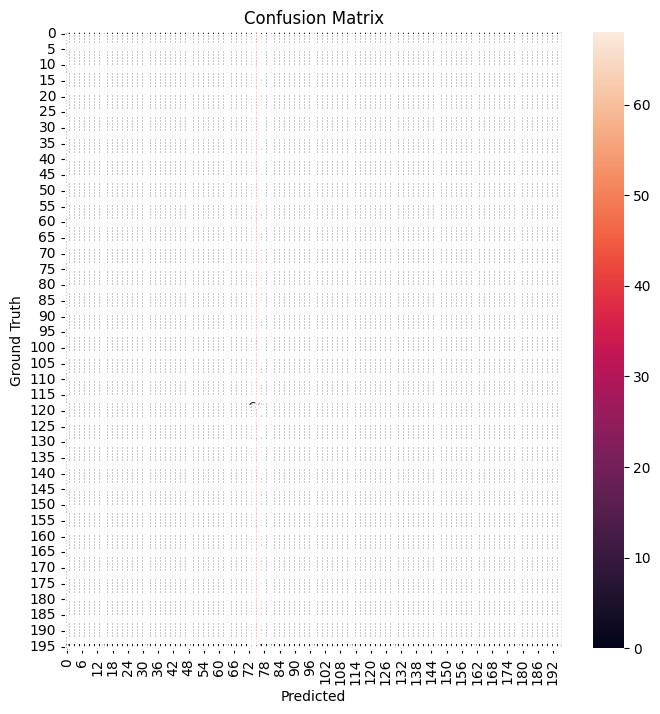

In [ ]:
# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, dim = 1)
        
        predictions.extend(predicted.cpu().numpy())     # Save predictions
        true_labels.extend(labels.cpu().numpy())        # Save ground truths

# Convert to arrays
predictions = np.array(predictions)
true_labels = np.array(true_labels)

conf_mat = confusion_matrix(true_labels, predictions)

plt.figure(figsize = (8,8))
sns.heatmap(conf_mat, annot=True, fmt = 'd')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Ground Truth")
plt.show()

In [ ]:
class_acc = []
total_samples_per_class = np.bincount(true_labels)
num_classes = max(true_labels)

for class_label in range(num_classes):
    class_mask = (true_labels == class_label)
    class_pred = predictions[class_mask]
    class_correct = np.sum(class_pred == class_label)
    class_acc.append(class_correct / total_samples_per_class[class_label])

# plt.figure(figsize = (12,6))
# plt.bar(range(num_classes), class_acc)
# plt.xlabel("Class")
# plt.ylabel("Accuracy")
# plt.title("Accuracy per Class")
# plt.xticks(range(num_classes))
# plt.show()

class_acc[75]


1.0

In [ ]:
np.unique(predictions)

array([75], dtype=int64)

### Plot training losses

ValueError: x and y must have same first dimension, but have shapes (10,) and (20360,)

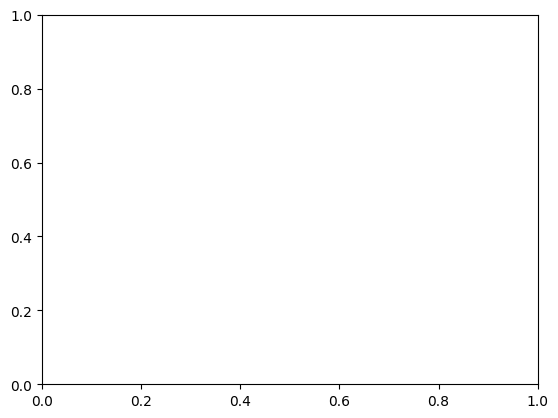

In [ ]:
plt.plot(range(1, num_epochs + 1), train_loss_list, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

## Model 2

In [58]:
def getTrainLoad(directory):
    data = datasets.ImageFolder(directory, 
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.RandomRotation(30),
                                transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=128, shuffle=True)

def getTestLoad(directory):
    data = datasets.ImageFolder(directory,
                                transform = transforms.Compose([transforms.Resize((244,244)),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]))
    return torch.utils.data.DataLoader(data, batch_size=32, shuffle=True)
trainLoad = getTrainLoad("./Stanford Cars Dataset/cars_train_classes")
validLoad = getTestLoad("./Stanford Cars Dataset/cars_val_classes")
testLoad = getTestLoad("./Stanford Cars Dataset/cars_test_classes")

In [59]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 196)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)
device = 'cuda'
model.to(device)

c:\Users\hai_f\anaconda3\envs\test\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\hai_f\anaconda3\envs\test\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [60]:
start = time.time()
epochs = 10
iterations = 0
val = 35
model.to(device)
model.train()

def validation(model, validloader, criterion):
    valid_loss = 0
    accuracy = 0
    model.to(device)
    for i, (images, labels) in enumerate(validloader):
        images, labels = images.to(device), labels.to(device)
        output = model.forward(images)
        valid_loss = valid_loss + criterion(output, labels).item()
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy = accuracy + equality.type(torch.FloatTensor).mean()
    return valid_loss, accuracy

v_loss_hist = list()
tr_loss_hist = list()
v_acc_hist = list()

for e in range(epochs):
    running_loss = 0
    for i, (inputs, labels) in enumerate(trainLoad):
        iterations += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        #validation
        if iterations % val == 0:
            model.eval()
            with torch.no_grad():
                valid_loss, accuracy = validation(model, validLoad, criterion)
            if (e + 1) > len(v_loss_hist):
                v_loss_hist.append(round(valid_loss/len(validLoad),3))
                tr_loss_hist.append(round(running_loss/val,3))
                v_acc_hist.append(round(float(accuracy/len(validLoad)),3))
            print(f"Epoch #  {e+1}, \
            Valid Loss: {round(valid_loss/len(validLoad),5)}, \
            Training Loss: {round(running_loss/val,5)}, \
            Valid Accuracy: {round(float(accuracy/len(validLoad)),5)}")
            model.train()
            lrscheduler.step(accuracy * 100)
end = time.time()
print("Training Complete.")
print("Training time in seconds:", end - start)

Epoch #  1,             Valid Loss: 4.82327,             Training Loss: 5.24827,             Valid Accuracy: 0.06262
Epoch #  2,             Valid Loss: 3.63479,             Training Loss: 0.65615,             Valid Accuracy: 0.20147
Epoch #  2,             Valid Loss: 2.63973,             Training Loss: 4.06669,             Valid Accuracy: 0.39056
Epoch #  3,             Valid Loss: 2.05699,             Training Loss: 0.78612,             Valid Accuracy: 0.50858
Epoch #  3,             Valid Loss: 1.64027,             Training Loss: 2.79781,             Valid Accuracy: 0.59755
Epoch #  4,             Valid Loss: 1.26621,             Training Loss: 0.69515,             Valid Accuracy: 0.6799
Epoch #  4,             Valid Loss: 0.88339,             Training Loss: 1.87962,             Valid Accuracy: 0.77721
Epoch #  5,             Valid Loss: 0.85447,             Training Loss: 0.58935,             Valid Accuracy: 0.76336
Epoch #  5,             Valid Loss: 0.61234,             Training

### Plots

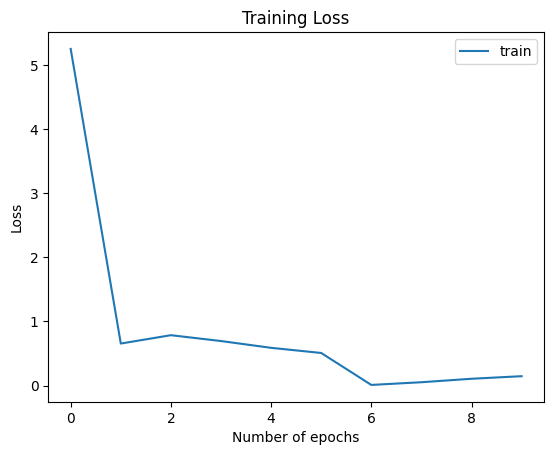

In [61]:
plt.plot(tr_loss_hist)
plt.title('Training Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper right')
plt.show()

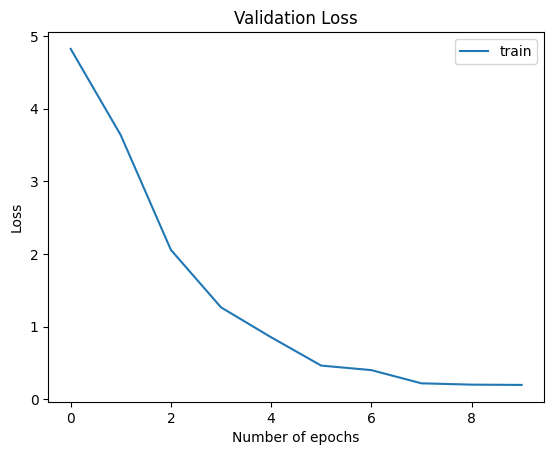

In [72]:
plt.plot(v_loss_hist)
plt.title('Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper right')
plt.show()

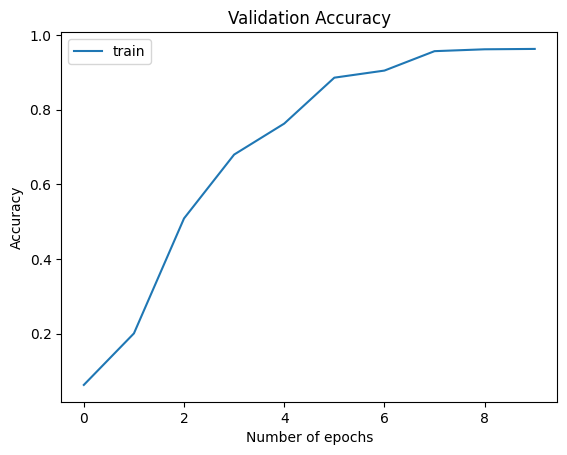

In [63]:
plt.plot(v_acc_hist)
plt.title('Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epochs')
plt.legend(['train'], loc='upper left')
plt.show()

In [69]:
model.to(device)
"""
Tests model accuracy with test images
"""
start = time.time()
total = 0
correct = 0
acc_hist = list()
tot_hist = list()
with torch.no_grad():
    for data in testLoad:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, guess = torch.max(outputs.data, 1) 
        total = total + labels.size(0) #total num of images
        correct = correct + (guess == labels).sum().item() #number correct
        acc_hist.append(correct)
        tot_hist.append(total)
end = time.time()
print("Total images tested in model:", len(test_annot["Class"]))
print("Total accurate predictions:", correct)
print(f"Accuracy of model w/ full test dataset fed: {round(100 * correct / total,8)}%")
print("Testing time in seconds:", round(end - start))

Total images tested in model: 8041
Total accurate predictions: 6258
Accuracy of model w/ full test dataset fed: 77.82614103%
Testing time in seconds: 61


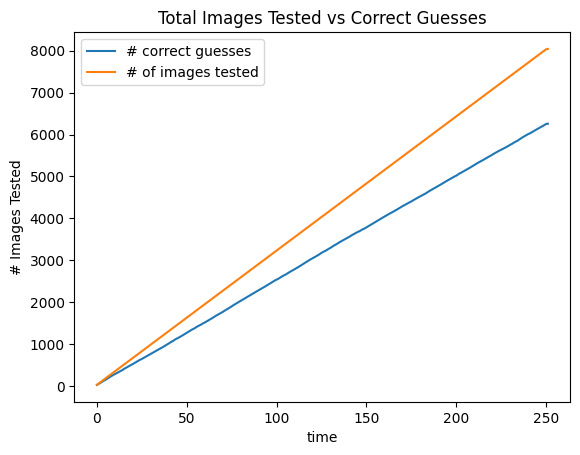

In [70]:
plt.plot(acc_hist)
plt.plot(tot_hist)
plt.title('Total Images Tested vs Correct Guesses')
plt.ylabel('# Images Tested')
plt.xlabel('time')
plt.legend(['# correct guesses', '# of images tested'], loc='upper left')
plt.show()

### Save model

In [71]:
# Save the model
torch.save(model.state_dict(), 'car_classifier.pth')
print("Model saved!")

Model saved!
